# Logistic Regression
***
**Author: Sasha Hall**

**Date: December 1, 2020**

**CSCI 4502 - Final Project**


This notebook is primarily used to create a logistic regression model to predict the profitability and success of various movies. The notebook contains a bit of pre-analysis and cleaning of the data as well as the code necessary to complete the logistic regression model using multiple variables. 


In [175]:
import numpy as np 
from scipy import stats
import pandas as pd
import statsmodels.api as sm 
import seaborn as sn
import matplotlib.pylab as plt 
%matplotlib inline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

# Importing and Cleaning Dataset
***
Create a dataframe to hold the dataset titled "tmdb_movies_data.csv".

Clean the dataset by removing any null or 0 values and drop the columns that do not contain numeric values. These columns are dropped because there are too many unique values in the non-numeric columns that prevent the logistic regression from being able to complete and converge in a given number of iterations.

Finally, create a profit column that finds the profit of the movie and then converts the profit into a binary value. The binary values is based on whether the movie had a positive profit or if the movie had a negative profit.

In [176]:
df = pd.read_csv('tmdb_movies_data.csv')
df = df[(df["budget"] != 0)]
df = df.drop(columns=["id", "imdb_id", "original_title", "cast", "homepage", "tagline", "keywords", "overview", 
                      "release_date", "production_companies", "genres", "director", "revenue_adj", "budget_adj"])
df = df[(df["revenue"] != 0)]

df = df.dropna()
profit = df['revenue'] - df['budget']
profit[profit > 0] = 1
profit[profit < 0] = 0
df["profit"] = profit

df.head()

,popularity,budget,revenue,runtime,vote_count,vote_average,release_year,profit
0,32.985763,150000000,1513528810,124,5562,6.5,2015,1
1,28.419936,150000000,378436354,120,6185,7.1,2015,1
2,13.112507,110000000,295238201,119,2480,6.3,2015,1
3,11.173104,200000000,2068178225,136,5292,7.5,2015,1
4,9.335014,190000000,1506249360,137,2947,7.3,2015,1


# Pre-Analysis
***
The first step was to look at the remaining variables in the dataset and see how each one correlates to the other variables. And, also look at the mean values for each attribute when grouped by profit. 

Both of these methods helped identify any relationships in the dataset. For example, it is clear to see that revenue and budget have a strong correlation, and so does popularity and vote count. However, release year and runtime have a weak correlation, and so does release year and vote average. 

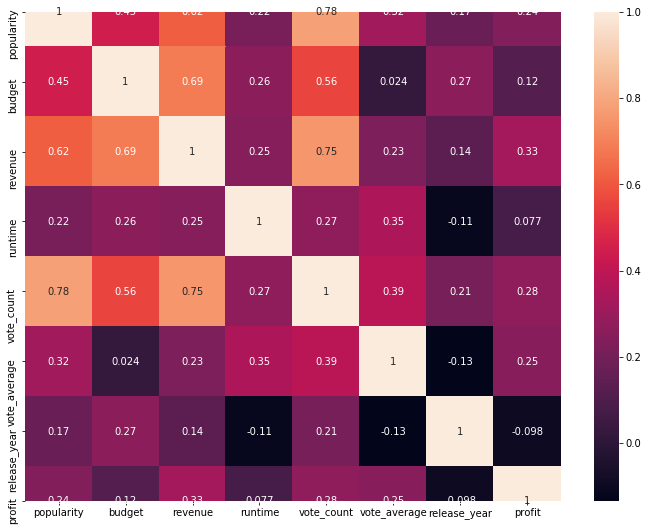

In [177]:
corrMatrix = df.corr()

f = plt.figure(figsize=(12,9))
sn.heatmap(corrMatrix, annot=True)
plt.show()

In [178]:
# dfNumericValues = df[["popularity", "budget", "revenue", "runtime", "vote_count", "vote_average", "release_year"]]
# dfNumericValues = dfNumericValues.dropna()

df.groupby('profit').mean()

,popularity,budget,revenue,runtime,vote_count,vote_average,release_year
profit,,,,,,,
0,0.617900,2.927455e+07,1.516038e+07,106.742804,137.924791,5.844104,2003.038997
1,1.413739,4.027515e+07,1.435196e+08,110.174586,678.689345,6.293377,2000.574874


The next step was seeing how imbalanced the dataset was in the number of movies that were profitable and the ones that were not. The graph below shows that the imbalance was pretty significant, with over 70% of the movies in the dataset being profitable.

Percentage of movies that have a positive profit:  0.7206225680933852
Percentage of movies that have a negative profit:  0.2793774319066148


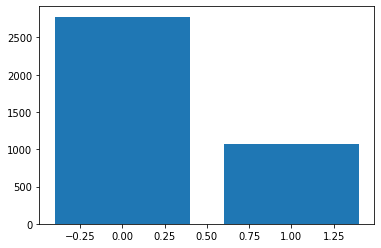

In [179]:
height = [0,0]
for i in df["profit"]:
    if(i > 0):
        height[0]+=1
    else:
        height[1]+=1
        
xValues = [0, 1]
plt.bar(xValues, height)
print("Percentage of movies that have a positive profit: ", height[0]/len(df["profit"]))
print("Percentage of movies that have a negative profit: ", height[1]/len(df["profit"]))

In order to remedy that imbalance in the dataset, a sample of the data needed to be taken so that the percentage of profitable to not profitable movies was closer to 50%.

# Balancing the Dataset
***
First dummy varibles needed to be created to help identify different movies that had the same variables. This explains why release year was a very prevalent variable because a lot of different movies overlapped on release year.

In [180]:
cat_vars=["popularity", "budget", "revenue", "vote_count", "vote_average","release_year"]
for var in cat_vars:
    cat_list='var'+'_'+var
    cat_list = pd.get_dummies(df[var], prefix=var)
    data1=df.join(cat_list)
    data=data1

cat_vars=["popularity", "budget", "revenue", "vote_count", "vote_average","release_year"]
data_vars=data.columns.values.tolist()
to_keep=[i for i in data_vars if i not in cat_vars]

data_final=data[to_keep]
data_final.columns

Index(['runtime', 'profit', 'release_year_1960', 'release_year_1961',
       'release_year_1962', 'release_year_1963', 'release_year_1964',
       'release_year_1965', 'release_year_1966', 'release_year_1967',
       'release_year_1968', 'release_year_1969', 'release_year_1970',
       'release_year_1971', 'release_year_1972', 'release_year_1973',
       'release_year_1974', 'release_year_1975', 'release_year_1976',
       'release_year_1977', 'release_year_1978', 'release_year_1979',
       'release_year_1980', 'release_year_1981', 'release_year_1982',
       'release_year_1983', 'release_year_1984', 'release_year_1985',
       'release_year_1986', 'release_year_1987', 'release_year_1988',
       'release_year_1989', 'release_year_1990', 'release_year_1991',
       'release_year_1992', 'release_year_1993', 'release_year_1994',
       'release_year_1995', 'release_year_1996', 'release_year_1997',
       'release_year_1998', 'release_year_1999', 'release_year_2000',
       'release_year

Then using the oversampling SMOTE method, we are going to balance the data. The way the SMOTE method works is by creating a synthetic version of the data that is choosen at random to create a new dataset.

In [181]:
X = data_final.loc[:, data_final.columns != 'profit']
y = data_final.loc[:, data_final.columns == 'profit']

os = SMOTE(random_state=0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
columns = X_train.columns
os_data_X,os_data_y=os.fit_sample(X_train, y_train)
os_data_X = pd.DataFrame(data=os_data_X,columns=columns )
os_data_y= pd.DataFrame(data=os_data_y,columns=['profit'])

# we can Check the numbers of our data
print("length of oversampled data is ",len(os_data_X))
print("Number of not profitable movies in oversampled data",len(os_data_y[os_data_y['profit']==0]))
print("Number of profitable movies",len(os_data_y[os_data_y['profit']==1]))
print("Proportion of not profitable movies in oversampled data is ",len(os_data_y[os_data_y['profit']==0])/len(os_data_X))
print("Proportion of profitable movies in oversampled data is ",len(os_data_y[os_data_y['profit']==1])/len(os_data_X))

length of oversampled data is  3886
Number of not profitable movies in oversampled data 1943
Number of profitable movies 1943
Proportion of not profitable movies in oversampled data is  0.5
Proportion of profitable movies in oversampled data is  0.5


# Setting Up the Logisitic Regression
***
The first step to set up the logistic regression was to work through the set of dummy variables created previously. By finding the support and ranking of the variables, you can take out the most important variables (as defined by a high ranking). 

In [182]:
data_final_vars=data_final.columns.values.tolist()
y=['profit']
X=[i for i in data_final_vars if i not in y]
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()
rfe = RFE(logreg, 20)
rfe = rfe.fit(os_data_X, os_data_y.values.ravel())
print(rfe.support_)
print(rfe.ranking_)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_features_to_select=20 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[False False  True  True False  True False  True  True False False False
  True  True  True  True  True  True  True  True False  True  True  True
 False  True False False  True False  True  True False False False False
 False False False False False False False False False False False False
 False False False False False False False False False]
[38 35  1  1 34  1 36  1  1 33 37 32  1  1  1  1  1  1  1  1  4  1  1  1
  2  1 21 23  1 12  1  1 15  8 20 31  6 28 13 24 19  9 11 25  3 29 16 18
 14 27 30 26 10 17 22  5  7]


In [183]:
cols = []

for i in range(0, len(data_final.columns.values)-1):
    if(rfe.ranking_[i] == 1):
        cols.append(data_final.columns.values[i])

print(cols)

['release_year_1960', 'release_year_1961', 'release_year_1963', 'release_year_1965', 'release_year_1966', 'release_year_1970', 'release_year_1971', 'release_year_1972', 'release_year_1973', 'release_year_1974', 'release_year_1975', 'release_year_1976', 'release_year_1977', 'release_year_1979', 'release_year_1980', 'release_year_1981', 'release_year_1983', 'release_year_1986', 'release_year_1988', 'release_year_1989']


Then the first round of logistic regression is run to identify which variables are not as strongly correlated or signficant than others. By looking the p-values, you can identify which variables are significant as long as the p-value is less than 0.05.

In [184]:
X=os_data_X[cols]
y=os_data_y['profit']

logit_model=sm.Logit(y,X)
result=logit_model.fit(method='bfgs')
print(result.summary())

         Current function value: 0.671486
         Iterations: 35
         Function evaluations: 39
         Gradient evaluations: 39
                           Logit Regression Results                           
Dep. Variable:                 profit   No. Observations:                 3886
Model:                          Logit   Df Residuals:                     3866
Method:                           MLE   Df Model:                           19
Date:                Tue, 01 Dec 2020   Pseudo R-squ.:                 0.03125
Time:                        14:34:49   Log-Likelihood:                -2609.4
converged:                      False   LL-Null:                       -2693.6
Covariance Type:            nonrobust   LLR p-value:                 5.966e-26
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
release_year_1960     1.9397      1.742      1.114      0.265 

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


If we look at the variables that have a p-value of less than 0.05, we see that the model is reduced significantly.

The remaining variables are: 
 - release_year_1961
 - release_year_1977 
 - release_year_1979
 - release_year_1981
 - release_year_1983
 - release_year_1989
 
Then the logistic regression is run again with only the significant variables.

In [185]:
cols=["release_year_1961", "release_year_1977", "release_year_1979", "release_year_1981", "release_year_1983", "release_year_1989"] 
X=os_data_X[cols]
y=os_data_y['profit']
logit_model=sm.Logit(y,X)
result=logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.684788
         Iterations 7
                         Results: Logit
Model:              Logit            Pseudo R-squared: 0.012     
Dependent Variable: profit           AIC:              5334.1693 
Date:               2020-12-01 14:34 BIC:              5371.7601 
No. Observations:   3886             Log-Likelihood:   -2661.1   
Df Model:           5                LL-Null:          -2693.6   
Df Residuals:       3880             LLR p-value:      1.1366e-12
Converged:          1.0000           Scale:            1.0000    
No. Iterations:     7.0000                                       
-----------------------------------------------------------------
                     Coef.  Std.Err.   z    P>|z|   [0.025 0.975]
-----------------------------------------------------------------
release_year_1961    1.9459   1.0690 1.8202 0.0687 -0.1494 4.0412
release_year_1977    2.5649   1.0377 2.4716 0.0134  0.5310 4.5989


# Running the Logisitic Regression Model
***
Now it is time to run the logisitic regression model again a testing dataset we created previously. Once the model is ran, you can see how accurate the model was and also look at the confusion matrix to see the breakdown of correctly versus incorrectly identified movies.

In [186]:
from sklearn import metrics
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

LogisticRegression()

In [187]:
y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.53


In [188]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_pred)
print(confusion_matrix)

[[593   6]
 [546  21]]
